In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap

In [3]:
# Step 1: Load the dataset
df = pd.read_csv('/kaggle/input/lending-lc/new_file_5000.csv')  # Adjust the path as needed


In [4]:
# Step 2: Define relevant columns
numeric_cols = ['fico_range_low', 'total_acc', 'annual_inc', 'int_rate', 'loan_amnt']
categorical_columns = ['issue_d', 'sub_grade', 'term', 'home_ownership', 'purpose',
                       'application_type', 'verification_status', 'addr_state', 'emp_length']

In [5]:
# Step 3: Data Cleaning - Filter out rows with missing values in selected columns
df_clean = df[numeric_cols + ['loan_status']].dropna()

In [6]:
# Step 4: Euclidean Distance Matrix and MST
distance_matrix = euclidean_distances(df_clean[numeric_cols])
adjacency_matrix = np.exp(-distance_matrix)
G = nx.Graph()
for i in range(df_clean.shape[0]):
    G.add_node(i, loan_status=df_clean.iloc[i]['loan_status'])
for i in range(len(distance_matrix)):
    for j in range(i + 1, len(distance_matrix)):
        G.add_edge(i, j, weight=distance_matrix[i, j])
mst_euclidean = nx.minimum_spanning_tree(G)

In [7]:
# Step 5: Gower Distance Matrix and MST
def gower_distance(X, numerical_columns, categorical_columns):
    scaler = MinMaxScaler()
    X_num_scaled = scaler.fit_transform(X[numerical_columns])
    X_cat = X[categorical_columns].astype(str).to_numpy()
    n_rows, n_cols = X_cat.shape
    cat_distances = np.zeros((n_rows, n_rows, n_cols))
    for col in range(n_cols):
        cat_distances[:, :, col] = (X_cat[:, None, col] != X_cat[None, :, col]).astype(int)
    gower_cat_dist = np.mean(cat_distances, axis=2)
    pairwise_diff = np.abs(X_num_scaled[:, np.newaxis, :] - X_num_scaled[np.newaxis, :, :])
    gower_num_dist = np.mean(pairwise_diff, axis=2)
    return (gower_num_dist + gower_cat_dist) / 2.0

In [8]:
gower_distance_matrix = gower_distance(df, numeric_cols, categorical_columns)
gower_adjacency_matrix = np.exp(-gower_distance_matrix)
G_gower = nx.Graph()
for i in range(df.shape[0]):
    G_gower.add_node(i, loan_status=df.iloc[i]['loan_status'])
for i in range(len(gower_distance_matrix)):
    for j in range(i + 1, len(gower_distance_matrix)):
        G_gower.add_edge(i, j, weight=gower_distance_matrix[i, j])
mst_gower = nx.minimum_spanning_tree(G_gower)

In [9]:
# Step 6: Compute Centrality Metrics
def compute_metrics(mst):
    degree_dict = dict(mst.degree())
    degree_centrality_dict = nx.degree_centrality(mst)
    betweenness_dict = nx.betweenness_centrality(mst, weight='weight')
    strength_dict = {node: sum(data['weight'] for _, _, data in mst.edges(node, data=True)) for node in mst.nodes()}
    pagerank_dict = nx.pagerank(mst, weight='weight')
    return pd.DataFrame({
        'Degree': degree_dict,
        'Degree Centrality': degree_centrality_dict,
        'Betweenness Centrality': betweenness_dict,
        'Strength': strength_dict,
        'PageRank': pagerank_dict
    })

In [10]:
metrics_df_euclidean = compute_metrics(mst_euclidean)


In [11]:
metrics_df_gower = compute_metrics(mst_gower)


In [12]:
# Step 7: Prepare Data for ML Model
borrower_features = ['loan_amnt', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high']
centrality_features = ['Degree', 'Degree Centrality', 'Betweenness Centrality', 'Strength', 'PageRank']
X_borrower = df[borrower_features]
y = df['loan_status']  # Target variable
X_euclidean = pd.concat([X_borrower, metrics_df_euclidean[centrality_features]], axis=1)
X_gower = pd.concat([X_borrower, metrics_df_gower[centrality_features]], axis=1)

In [13]:
# Step 8: Train-Test Split
X_train_borrower, X_test_borrower, y_train, y_test = train_test_split(X_borrower, y, test_size=0.2, random_state=42)
X_train_euclidean, X_test_euclidean, _, _ = train_test_split(X_euclidean, y, test_size=0.2, random_state=42)
X_train_gower, X_test_gower, _, _ = train_test_split(X_gower, y, test_size=0.2, random_state=42)

In [14]:
# Step 9: Train Models
model_borrower = RandomForestClassifier().fit(X_train_borrower, y_train)
model_euclidean = RandomForestClassifier().fit(X_train_euclidean, y_train)
model_gower = RandomForestClassifier().fit(X_train_gower, y_train)

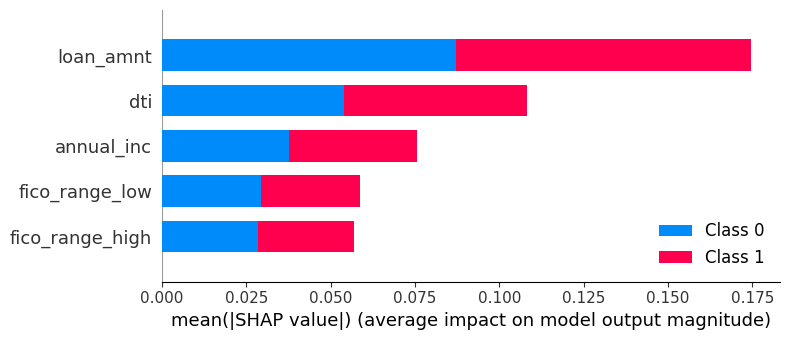

In [15]:
# Step 10: SHAP Analysis
explainer = shap.TreeExplainer(model_borrower)
shap_values_borrower = explainer.shap_values(X_test_borrower)
shap.summary_plot(shap_values_borrower, X_test_borrower, feature_names=X_borrower.columns)

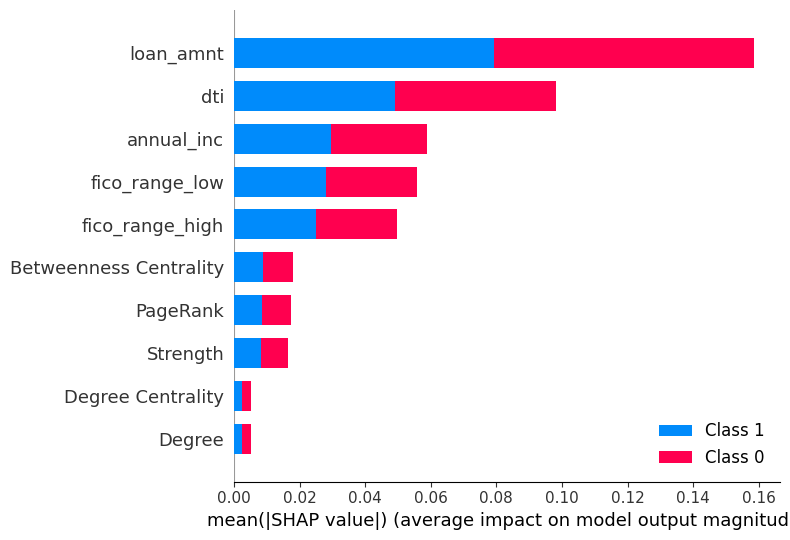

In [16]:
explainer = shap.TreeExplainer(model_euclidean)
shap_values_euclidean = explainer.shap_values(X_test_euclidean)
shap.summary_plot(shap_values_euclidean, X_test_euclidean, feature_names=X_euclidean.columns)

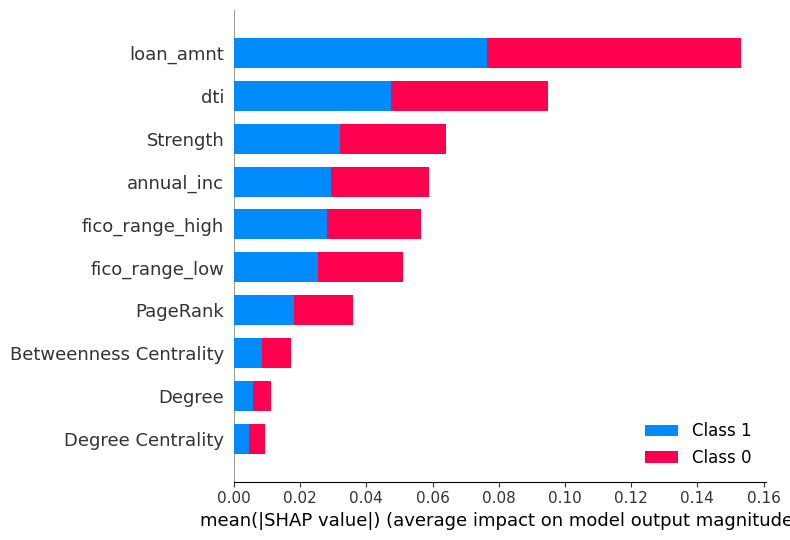

In [17]:
explainer = shap.TreeExplainer(model_gower)
shap_values_gower = explainer.shap_values(X_test_gower)
shap.summary_plot(shap_values_gower, X_test_gower, feature_names=X_gower.columns)

In [18]:
# Step 11: Evaluate Models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }

In [19]:
metrics_borrower = evaluate_model(model_borrower, X_test_borrower, y_test)
metrics_euclidean = evaluate_model(model_euclidean, X_test_euclidean, y_test)
metrics_gower = evaluate_model(model_gower, X_test_gower, y_test)

In [20]:
# Display results
print("Metrics for Borrower attributes only:", metrics_borrower)
print("Metrics for Euclidean-based model:", metrics_euclidean)
print("Metrics for Gower-based model:", metrics_gower)

Metrics for Borrower attributes only: {'Accuracy': 0.873, 'Precision': 0.8967334035827187, 'Recall': 0.9670454545454545, 'F1 Score': 0.9305631492618918, 'AUC': 0.7646022727272728}
Metrics for Euclidean-based model: {'Accuracy': 0.886, 'Precision': 0.8989583333333333, 'Recall': 0.9806818181818182, 'F1 Score': 0.9380434782608695, 'AUC': 0.7698626893939394}
Metrics for Gower-based model: {'Accuracy': 0.886, 'Precision': 0.8964803312629399, 'Recall': 0.9840909090909091, 'F1 Score': 0.9382448537378115, 'AUC': 0.8133049242424243}


In [21]:
from xgboost import XGBClassifier
import shap

In [26]:
# Initialize the XGBoost classifier
xgb_euclidean = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_gower = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


In [27]:
# Train the XGBoost model on Euclidean-based features
xgb_euclidean.fit(X_train_euclidean, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [28]:
# Train the XGBoost model on Gower-based features
xgb_gower.fit(X_train_gower, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [29]:
# Evaluate the XGBoost model on Euclidean-based features
y_pred_euclidean_xgb = xgb_euclidean.predict(X_test_euclidean)
accuracy_euclidean_xgb = accuracy_score(y_test, y_pred_euclidean_xgb)
precision_euclidean_xgb = precision_score(y_test, y_pred_euclidean_xgb)
recall_euclidean_xgb = recall_score(y_test, y_pred_euclidean_xgb)
f1_euclidean_xgb = f1_score(y_test, y_pred_euclidean_xgb)
auc_euclidean_xgb = roc_auc_score(y_test, y_pred_euclidean_xgb)


In [30]:
print("XGBoost Euclidean MST Model Performance:")
print(f"Accuracy: {accuracy_euclidean_xgb}")
print(f"Precision: {precision_euclidean_xgb}")
print(f"Recall: {recall_euclidean_xgb}")
print(f"F1 Score: {f1_euclidean_xgb}")
print(f"AUC Score: {auc_euclidean_xgb}")


XGBoost Euclidean MST Model Performance:
Accuracy: 0.872
Precision: 0.9025695931477516
Recall: 0.9579545454545455
F1 Score: 0.9294377067254687
AUC Score: 0.5998106060606061


In [31]:
# Evaluate the XGBoost model on Gower-based features
y_pred_gower_xgb = xgb_gower.predict(X_test_gower)
accuracy_gower_xgb = accuracy_score(y_test, y_pred_gower_xgb)
precision_gower_xgb = precision_score(y_test, y_pred_gower_xgb)
recall_gower_xgb = recall_score(y_test, y_pred_gower_xgb)
f1_gower_xgb = f1_score(y_test, y_pred_gower_xgb)
auc_gower_xgb = roc_auc_score(y_test, y_pred_gower_xgb)


In [32]:
print("\nXGBoost Gower MST Model Performance:")
print(f"Accuracy: {accuracy_gower_xgb}")
print(f"Precision: {precision_gower_xgb}")
print(f"Recall: {recall_gower_xgb}")
print(f"F1 Score: {f1_gower_xgb}")
print(f"AUC Score: {auc_gower_xgb}")



XGBoost Gower MST Model Performance:
Accuracy: 0.889
Precision: 0.9112299465240642
Recall: 0.9681818181818181
F1 Score: 0.9388429752066115
AUC Score: 0.6382575757575757


In [33]:
# SHAP Analysis for XGBoost on Euclidean-based features
explainer_xgb_euclidean = shap.Explainer(xgb_euclidean, X_train_euclidean)
shap_values_euclidean_xgb = explainer_xgb_euclidean(X_test_euclidean)



SHAP Feature Importance for XGBoost with Euclidean MST-based Features:


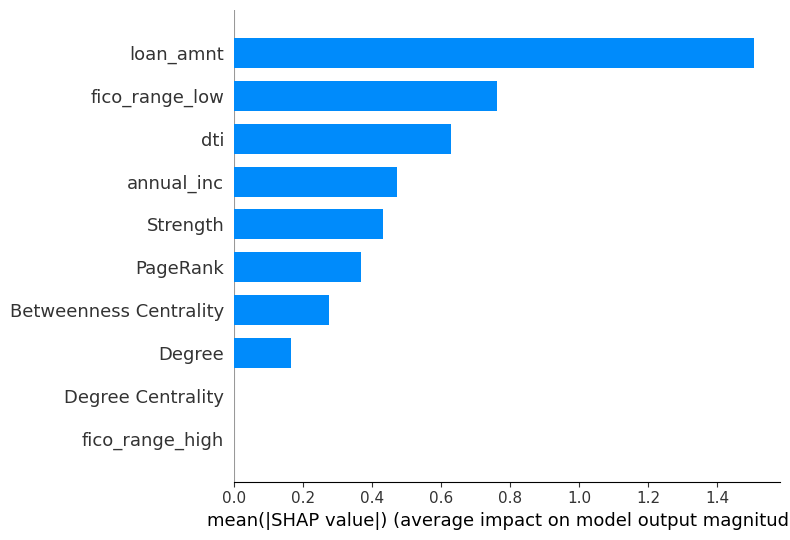

In [34]:
print("\nSHAP Feature Importance for XGBoost with Euclidean MST-based Features:")
shap.summary_plot(shap_values_euclidean_xgb, X_test_euclidean, plot_type="bar", max_display=10)


In [35]:
# SHAP Analysis for XGBoost on Gower-based features
explainer_xgb_gower = shap.Explainer(xgb_gower, X_train_gower)
shap_values_gower_xgb = explainer_xgb_gower(X_test_gower)



SHAP Feature Importance for XGBoost with Gower MST-based Features:


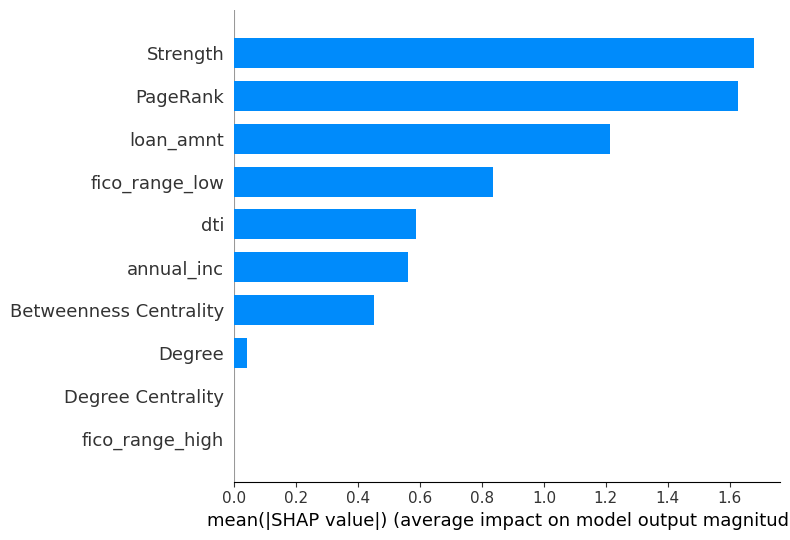

In [36]:
print("\nSHAP Feature Importance for XGBoost with Gower MST-based Features:")
shap.summary_plot(shap_values_gower_xgb, X_test_gower, plot_type="bar", max_display=10)

In [37]:
from sklearn.linear_model import LogisticRegression


In [40]:
# Train Logistic Regression models
logreg_borrower = LogisticRegression(max_iter=1000, random_state=42).fit(X_train_borrower, y_train)
logreg_euclidean = LogisticRegression(max_iter=1000, random_state=42).fit(X_train_euclidean, y_train)
logreg_gower = LogisticRegression(max_iter=1000, random_state=42).fit(X_train_gower, y_train)

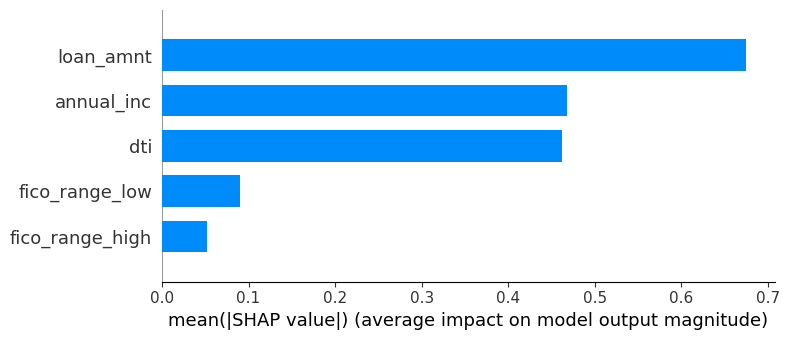

In [41]:
# SHAP Analysis for Logistic Regression models
explainer_borrower_logreg = shap.LinearExplainer(logreg_borrower, X_train_borrower)
shap_values_borrower_logreg = explainer_borrower_logreg.shap_values(X_test_borrower)
shap.summary_plot(shap_values_borrower_logreg, X_test_borrower, feature_names=X_borrower.columns, plot_type="bar", max_display=10)

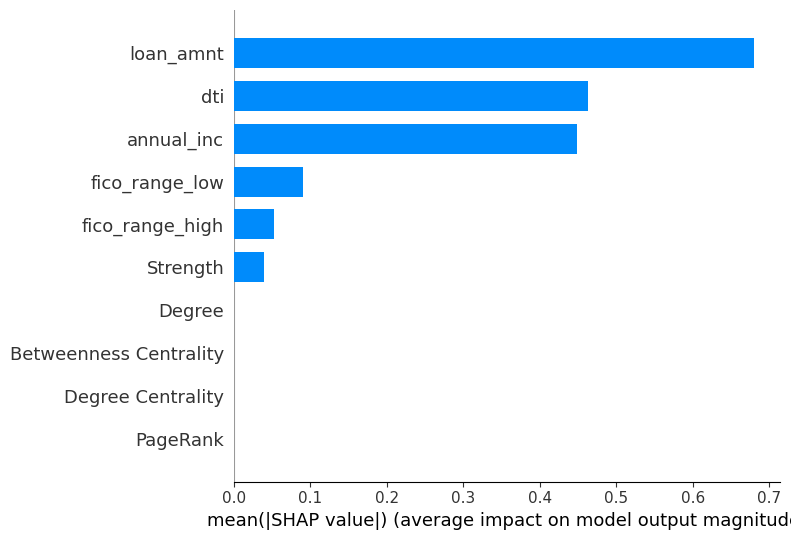

In [42]:
explainer_euclidean_logreg = shap.LinearExplainer(logreg_euclidean, X_train_euclidean)
shap_values_euclidean_logreg = explainer_euclidean_logreg.shap_values(X_test_euclidean)
shap.summary_plot(shap_values_euclidean_logreg, X_test_euclidean, feature_names=X_euclidean.columns, plot_type="bar", max_display=10)

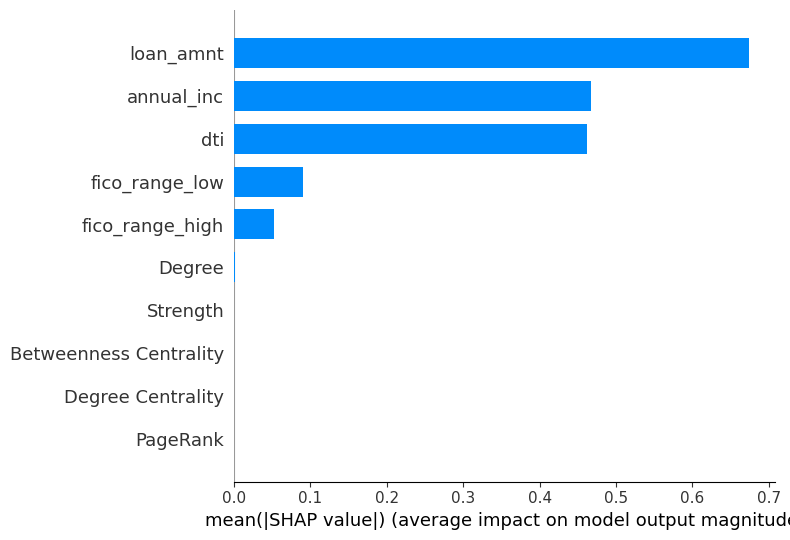

In [43]:
explainer_gower_logreg = shap.LinearExplainer(logreg_gower, X_train_gower)
shap_values_gower_logreg = explainer_gower_logreg.shap_values(X_test_gower)
shap.summary_plot(shap_values_gower_logreg, X_test_gower, feature_names=X_gower.columns, plot_type="bar", max_display=10)


In [44]:
# Evaluate Logistic Regression Models
metrics_borrower_logreg = evaluate_model(logreg_borrower, X_test_borrower, y_test)
metrics_euclidean_logreg = evaluate_model(logreg_euclidean, X_test_euclidean, y_test)
metrics_gower_logreg = evaluate_model(logreg_gower, X_test_gower, y_test)


In [45]:
# Display Logistic Regression results
print("Logistic Regression Metrics for Borrower attributes only:", metrics_borrower_logreg)
print("Logistic Regression Metrics for Euclidean-based model:", metrics_euclidean_logreg)
print("Logistic Regression Metrics for Gower-based model:", metrics_gower_logreg)

Logistic Regression Metrics for Borrower attributes only: {'Accuracy': 0.879, 'Precision': 0.8852791878172589, 'Recall': 0.990909090909091, 'F1 Score': 0.9351206434316354, 'AUC': 0.7820928030303032}
Logistic Regression Metrics for Euclidean-based model: {'Accuracy': 0.879, 'Precision': 0.8852791878172589, 'Recall': 0.990909090909091, 'F1 Score': 0.9351206434316354, 'AUC': 0.7804071969696971}
Logistic Regression Metrics for Gower-based model: {'Accuracy': 0.879, 'Precision': 0.8852791878172589, 'Recall': 0.990909090909091, 'F1 Score': 0.9351206434316354, 'AUC': 0.7820549242424242}


In [46]:
from xgboost import XGBClassifier


In [47]:
# Train XGBoost models
xgb_borrower = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_borrower.fit(X_train_borrower, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [48]:
xgb_euclidean = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_euclidean.fit(X_train_euclidean, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [49]:
xgb_gower = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_gower.fit(X_train_gower, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

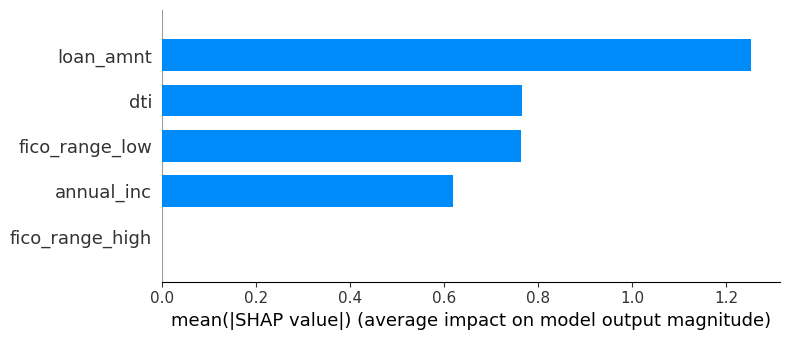

In [50]:
# SHAP Analysis for XGBoost models
explainer_borrower_xgb = shap.TreeExplainer(xgb_borrower)
shap_values_borrower_xgb = explainer_borrower_xgb.shap_values(X_test_borrower)
shap.summary_plot(shap_values_borrower_xgb, X_test_borrower, feature_names=X_borrower.columns, plot_type="bar", max_display=10)


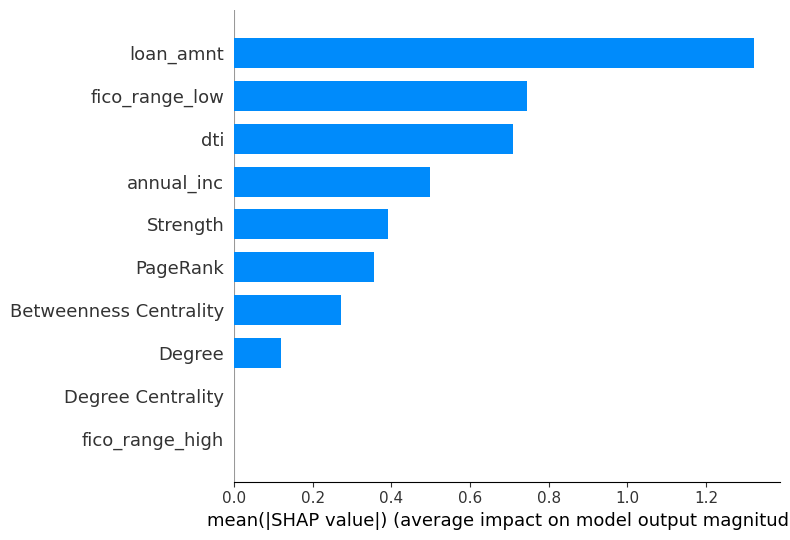

In [51]:
explainer_euclidean_xgb = shap.TreeExplainer(xgb_euclidean)
shap_values_euclidean_xgb = explainer_euclidean_xgb.shap_values(X_test_euclidean)
shap.summary_plot(shap_values_euclidean_xgb, X_test_euclidean, feature_names=X_euclidean.columns, plot_type="bar", max_display=10)


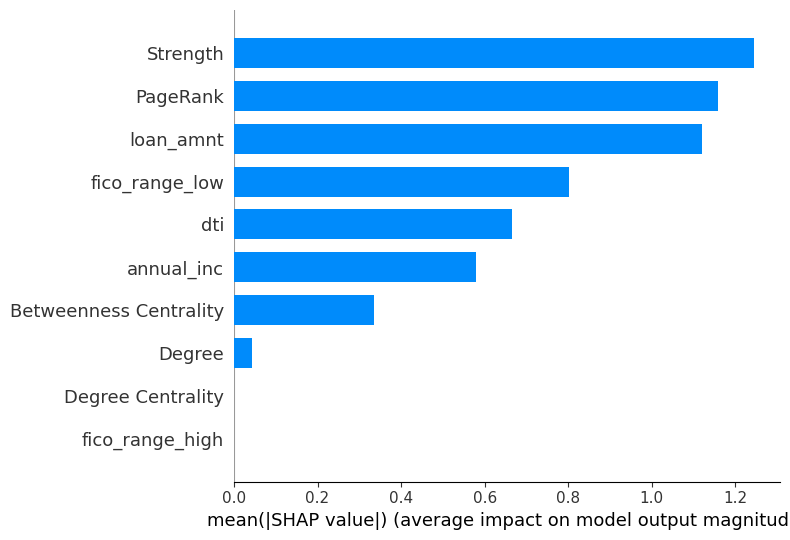

In [52]:
explainer_gower_xgb = shap.TreeExplainer(xgb_gower)
shap_values_gower_xgb = explainer_gower_xgb.shap_values(X_test_gower)
shap.summary_plot(shap_values_gower_xgb, X_test_gower, feature_names=X_gower.columns, plot_type="bar", max_display=10)


In [53]:
# Evaluate XGBoost Models
metrics_borrower_xgb = evaluate_model(xgb_borrower, X_test_borrower, y_test)
metrics_euclidean_xgb = evaluate_model(xgb_euclidean, X_test_euclidean, y_test)
metrics_gower_xgb = evaluate_model(xgb_gower, X_test_gower, y_test)


In [54]:
# Display XGBoost results
print("XGBoost Metrics for Borrower attributes only:", metrics_borrower_xgb)
print("XGBoost Metrics for Euclidean-based model:", metrics_euclidean_xgb)
print("XGBoost Metrics for Gower-based model:", metrics_gower_xgb)

XGBoost Metrics for Borrower attributes only: {'Accuracy': 0.869, 'Precision': 0.9005347593582887, 'Recall': 0.9568181818181818, 'F1 Score': 0.9278236914600551, 'AUC': 0.7599905303030302}
XGBoost Metrics for Euclidean-based model: {'Accuracy': 0.872, 'Precision': 0.9025695931477516, 'Recall': 0.9579545454545455, 'F1 Score': 0.9294377067254687, 'AUC': 0.7661837121212121}
XGBoost Metrics for Gower-based model: {'Accuracy': 0.889, 'Precision': 0.9112299465240642, 'Recall': 0.9681818181818181, 'F1 Score': 0.9388429752066115, 'AUC': 0.818125}
